# Performance Analysis with Alphalens

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path
from collections import defaultdict
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from alphalens.tears import (create_returns_tear_sheet,
                             create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.performance import mean_return_by_quantile
from alphalens.plotting import plot_quantile_returns_bar
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return

In [3]:
sns.set_style('whitegrid')

In [4]:
np.random.seed(42)
idx = pd.IndexSlice

In [5]:
results_path = Path('results', 'asset_pricing')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Alphalens Analysis

### Load predictions

In [6]:
DATA_STORE = Path(results_path / 'data.h5')

In [7]:
predictions = pd.read_hdf(results_path / 'predictions.h5', 'predictions')

In [8]:
factor = (predictions.mean(axis=1)
          .unstack('ticker')
          .resample('W-FRI', level='date')
          .last()
          .stack()
          .tz_localize('UTC', level='date')
          .sort_index())
tickers = factor.index.get_level_values('ticker').unique()

### Get trade prices

In [9]:
def get_trade_prices(tickers):
    prices = pd.read_hdf(DATA_STORE, 'stocks/prices/adjusted')
    prices.index.names = ['ticker', 'date']
    prices = prices.loc[idx[tickers, '2014':'2020'], 'open']
    return (prices
            .unstack('ticker')
            .sort_index()
            .shift(-1)
            .resample('W-FRI', level='date')
            .last()
            .tz_localize('UTC'))

In [10]:
trade_prices = get_trade_prices(tickers)

In [11]:
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 314 entries, 2014-01-03 00:00:00+00:00 to 2020-01-03 00:00:00+00:00
Freq: W-FRI
Columns: 4420 entries, A to ZYXI
dtypes: float64(4420)
memory usage: 10.6 MB


In [17]:
trade_prices.to_hdf('tmp.h5', 'trade_prices')

### Generate tearsheet input

In [12]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(5, 10, 21)).sort_index()
factor_data.info()

Dropped 20.8% entries from factor data: 20.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 910402 entries, (Timestamp('2015-01-09 00:00:00+0000', tz='UTC', freq='C'), 'A') to (Timestamp('2019-08-09 00:00:00+0000', tz='UTC', freq='C'), 'ZYXI')
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   5D               910402 non-null  float64
 1   10D              910402 non-null  float64
 2   21D              910402 non-null  float64
 3   factor           910402 non-null  float32
 4   factor_quantile  910402 non-null  int64  
dtypes: float32(1), float64(3), int64(1)
memory usage: 34.9+ MB


### Create Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-1.884710,0.011363,-0.073051,0.059347,182175,20.010391
2,-0.090773,0.038465,-0.018442,0.020205,182031,19.994574
3,-0.047706,0.071215,0.009813,0.017372,182035,19.995013
4,-0.012776,0.106919,0.036541,0.018783,182031,19.994574
5,0.011556,0.388834,0.081942,0.037429,182130,20.005448


Returns Analysis


,5D,10D,21D
Ann. alpha,-0.013,-0.032,-0.025
beta,-0.075,-0.079,-0.107
Mean Period Wise Return Top Quantile (bps),-7.920,-10.585,-13.163
Mean Period Wise Return Bottom Quantile (bps),15.317,21.989,23.317
Mean Period Wise Spread (bps),-23.237,-32.475,-36.351


Information Analysis


,5D,10D,21D
IC Mean,-0.002,-0.009,-0.014
IC Std.,0.078,0.068,0.058
Risk-Adjusted IC,-0.026,-0.133,-0.242
t-stat(IC),-0.396,-2.062,-3.754
p-value(IC),0.692,0.040,0.000
IC Skew,-0.180,-0.607,0.203
IC Kurtosis,0.656,2.091,0.391


Turnover Analysis


,5D,10D,21D
Quantile 1 Mean Turnover,0.553,0.630,0.727
Quantile 2 Mean Turnover,0.730,0.759,0.788
Quantile 3 Mean Turnover,0.751,0.773,0.791
Quantile 4 Mean Turnover,0.730,0.756,0.782
Quantile 5 Mean Turnover,0.572,0.646,0.750


,5D,10D,21D
Mean Factor Rank Autocorrelation,0.459,0.327,0.133


<Figure size 432x288 with 0 Axes>

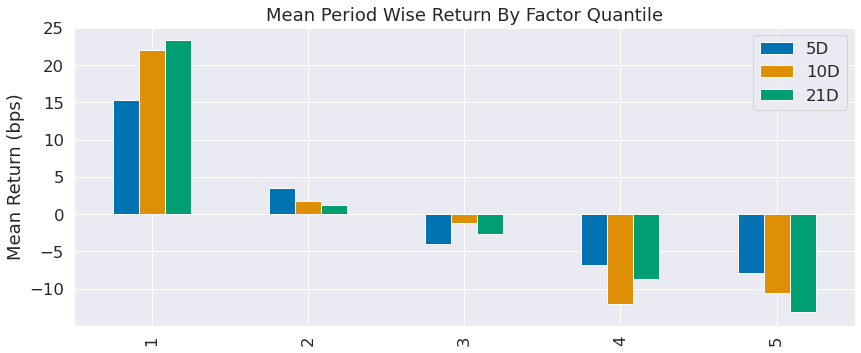

In [13]:
create_summary_tear_sheet(factor_data)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-1.884710,0.011363,-0.073051,0.059347,182175,20.010391
2,-0.090773,0.038465,-0.018442,0.020205,182031,19.994574
3,-0.047706,0.071215,0.009813,0.017372,182035,19.995013
4,-0.012776,0.106919,0.036541,0.018783,182031,19.994574
5,0.011556,0.388834,0.081942,0.037429,182130,20.005448


Returns Analysis


,5D,10D,21D
Ann. alpha,-0.013,-0.032,-0.025
beta,-0.075,-0.079,-0.107
Mean Period Wise Return Top Quantile (bps),-7.920,-10.585,-13.163
Mean Period Wise Return Bottom Quantile (bps),15.317,21.989,23.317
Mean Period Wise Spread (bps),-23.237,-32.475,-36.351


<Figure size 432x288 with 0 Axes>

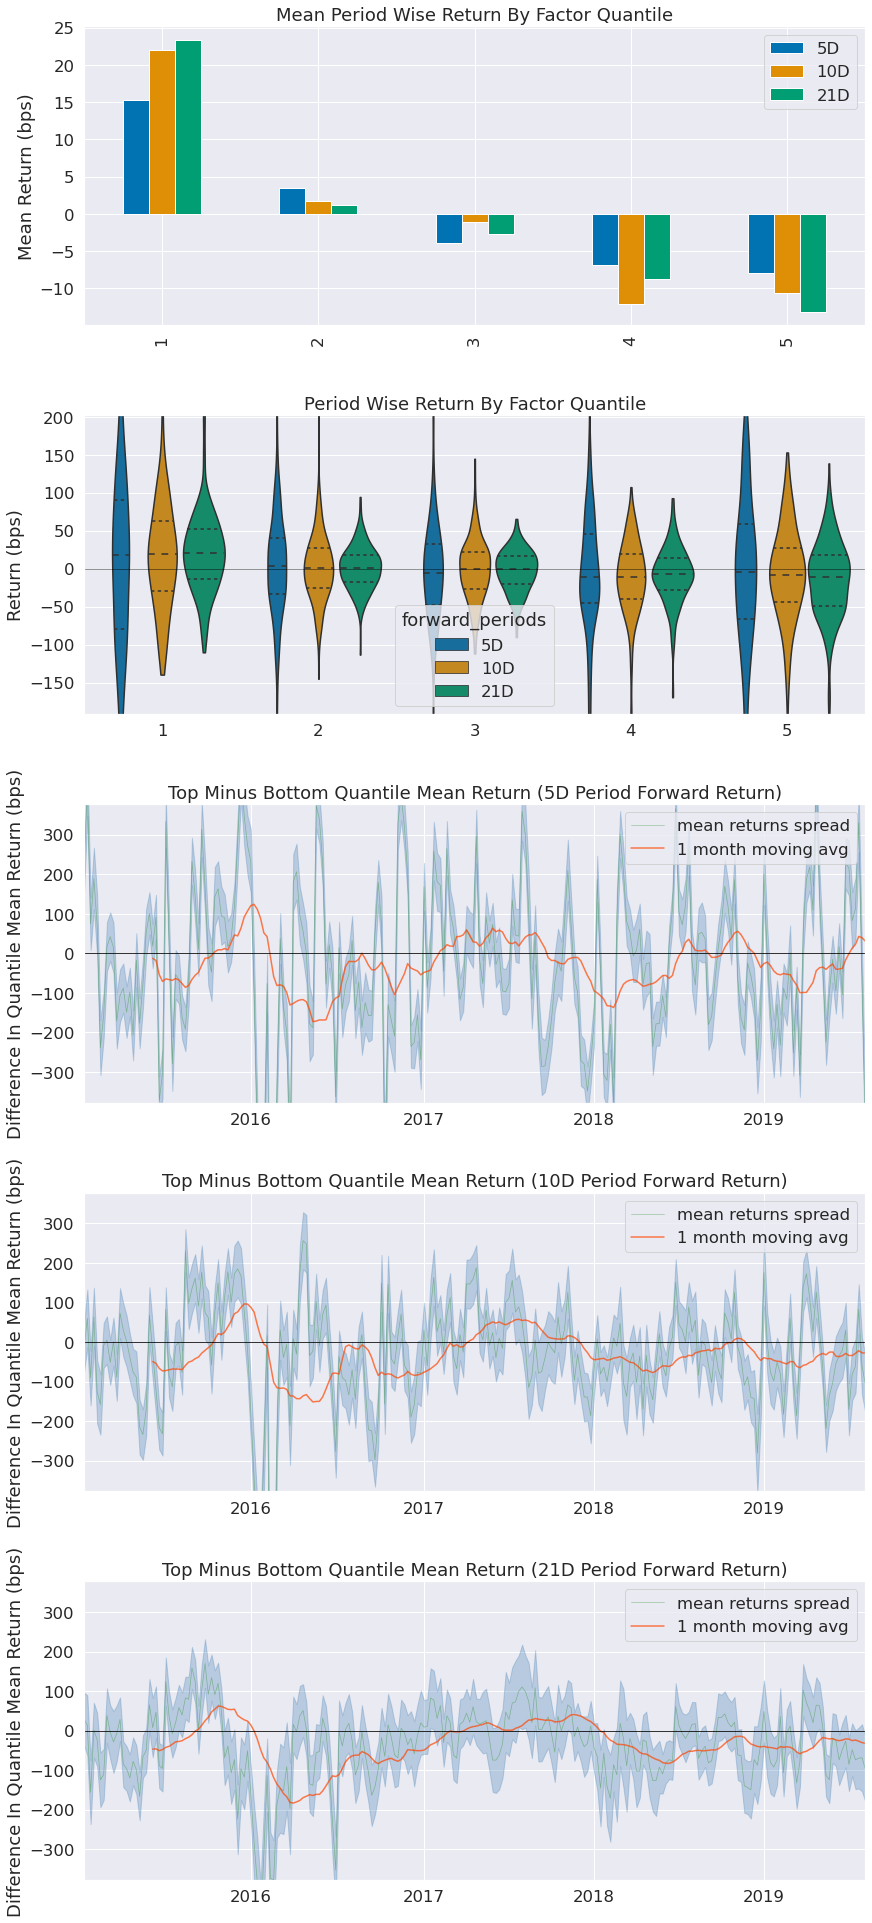

Information Analysis


,5D,10D,21D
IC Mean,-0.002,-0.009,-0.014
IC Std.,0.078,0.068,0.058
Risk-Adjusted IC,-0.026,-0.133,-0.242
t-stat(IC),-0.396,-2.062,-3.754
p-value(IC),0.692,0.040,0.000
IC Skew,-0.180,-0.607,0.203
IC Kurtosis,0.656,2.091,0.391


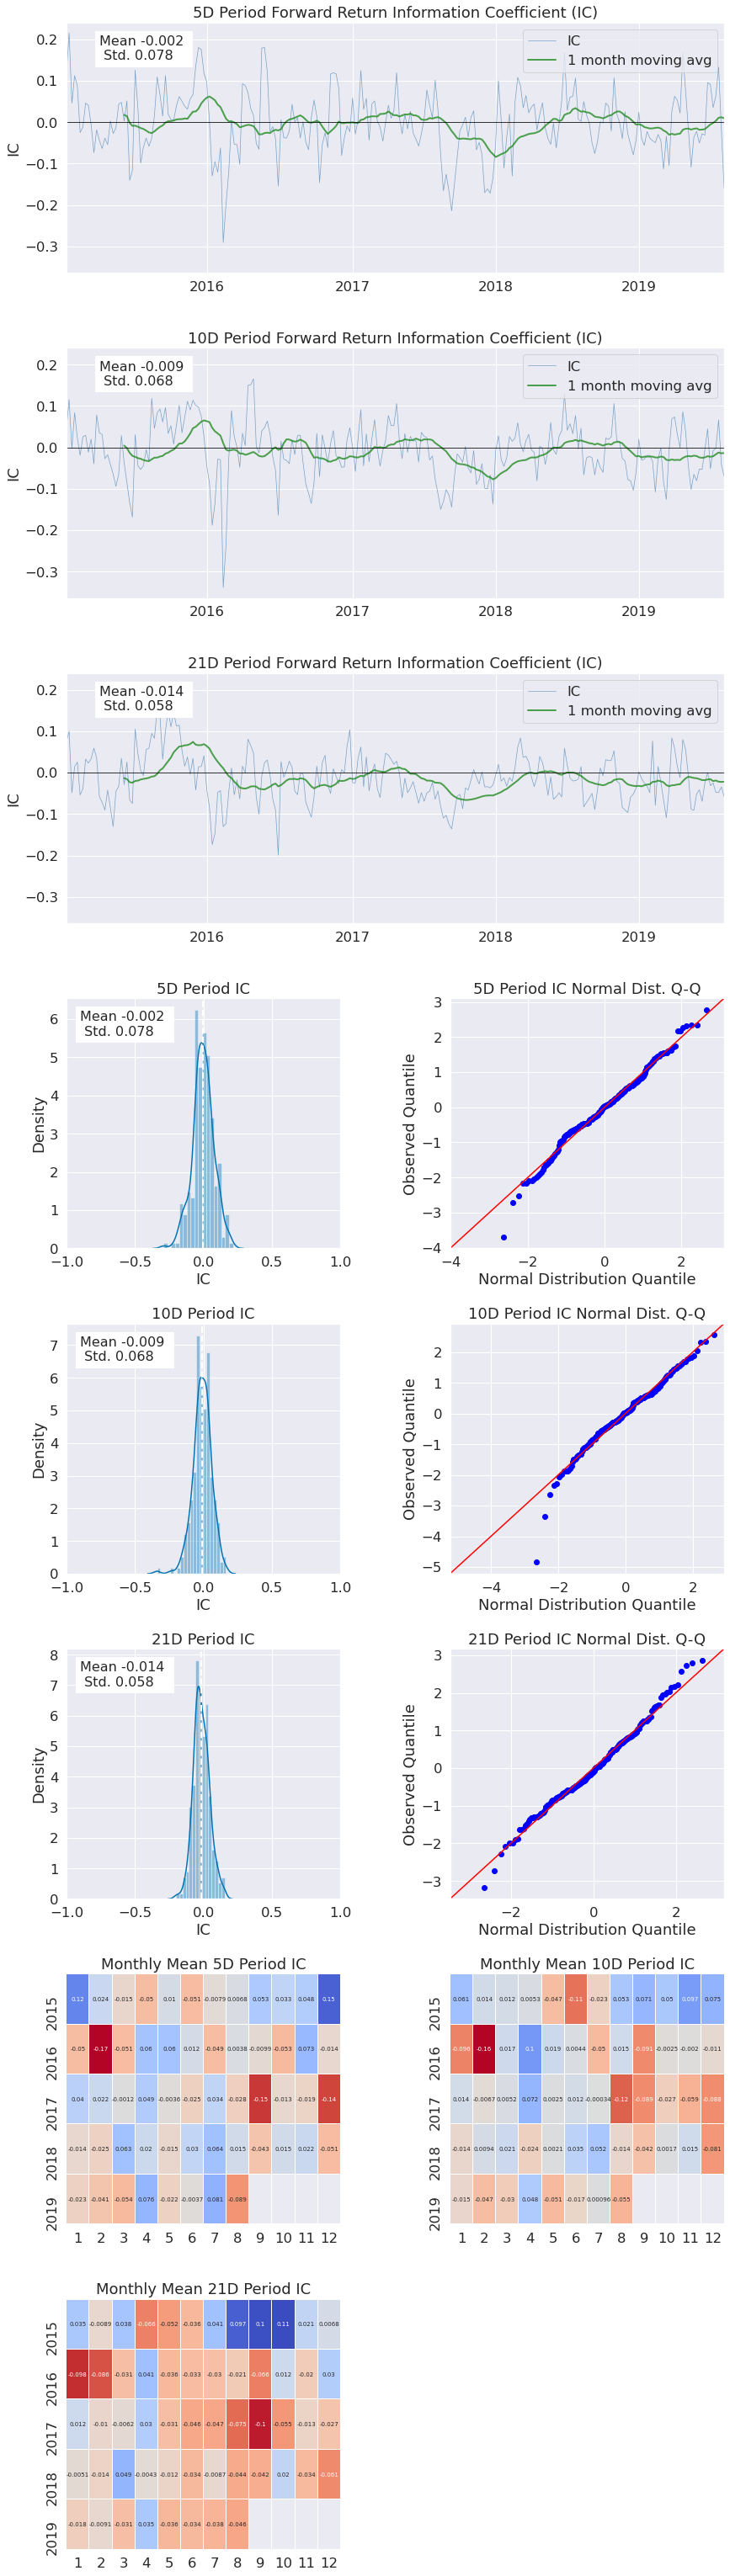

AttributeError: 'Index' object has no attribute 'get_values'

In [14]:
create_full_tear_sheet(factor_data)